# Evaluation (DBLP)

In [1]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2

!mkdir ./cache
!mkdir ./cache/dblp

mkdir: cannot create directory ‘./cache’: File exists
mkdir: cannot create directory ‘./cache/dblp’: File exists


In [2]:
from impl.datasets.dblp import DBLP
from impl.pairs.doc2vec import D2VPairs
from impl.pairs.deepwalk import DWPairs
from impl.model.skipgram import SGNS
from impl.model.jce import JCE
from impl.utils.eval import eval_model, plot_evals
from gensim.models import Word2Vec, doc2vec
import numpy as np
import psutil

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Use importlib.util.find_spec() instead.
  """Entry point for launching an IPython kernel.


## Dataset

In [3]:
dataset = DBLP(content_filename='./datasets/dblp/dblp.content', cites_filename='./datasets/dblp/dblp.cites')

print("Tagged docs: ", dataset.get_tagged_docs()[0:2])

Get tagged docs: 18448it [00:14, 1292.94it/s]

Tagged docs:  [TaggedDocument(words=['0', '1', '2', '3', '4', '5'], tags=['0']), TaggedDocument(words=['6', '7', '8', '9', '10'], tags=['1'])]


## Parameters

In [4]:
run_d2v = True
run_dw = True
run_jce = True
cache = True

params_d2v = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0,
       "min_count": 5
   },
   "model": {
       "workers": 0, # Slower, but fixes issues with DataLoader getting killed due to shm size
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 16,
       "cache_file": "./cache/dblp/d2v"
   }
}

params_dw = {
   "pairs": {
       "neg_samples": 10,
       "sample": 0.001,
       "min_count": 5,
       "walk_length": 40,
       "num_walks": 10,
       "window_size": 5
   },
   "model": {
       "workers": 0,  # Slower, but fixes issues with DataLoader getting killed due to shm size
       "dim": 100,
       "alpha": 0.001,
       "iterations": 10,
       "batch_size": 2000,
       "cache_file": "./cache/dblp/dw"
   }
}

params_jce_concat = {
    "workers": 0,
    "dim": 200,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/dblp/jce_concat"
}
params_jce_compare = {
    "workers": 0,  # Slower, but fixes issues with DataLoader getting killed due to shm size
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/dblp/jce_compare"
}
params_jce_sine = {
    "workers": 0,  # Slower, but fixes issues with DataLoader getting killed due to shm size
    "dim": 100,
    "alpha": 0.001,
    "iterations": 10,
    "batch_sizes": [params_d2v["model"]["batch_size"],params_dw["model"]["batch_size"]],
    "cache_file": "./cache/dblp/jce_sine"
}

## Input Pairs

In [5]:
d2vpairs = D2VPairs(dataset=dataset, **params_d2v["pairs"])
dwpairs = DWPairs(dataset=dataset, **params_dw["pairs"])

DeepWalk: Generate walks:   0%|          | 0/10 [00:00<?, ?it/s]

Removed 0 unknown nodes


DeepWalk: Generate walks: 100%|██████████| 10/10 [03:58<00:00, 23.88s/it]


## Doc2Vec

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2V:  [(0.6872013961626224, 0.0034868591141668714), (0.7593018213356462, 0.0032586308921156324)]


Evaluating model: 100%|██████████| 10/10 [05:03<00:00, 30.31s/it]


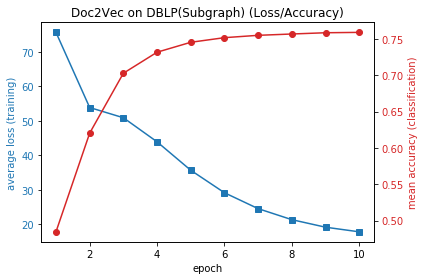

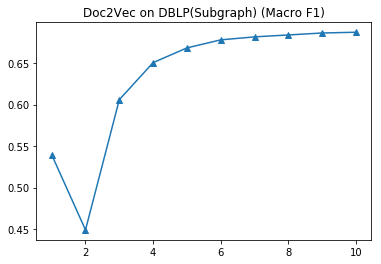

In [6]:
if run_d2v:
    d2vmodel = SGNS(d2vpairs, cache=cache, **params_d2v["model"])
    d2vemb = d2vmodel.embeddings[str(params_d2v["model"]["iterations"])]

    print("Eval D2V: ", eval_model(d2vemb, dataset=dataset))
    # gensim_d2v = doc2vec.Doc2Vec(dataset.get_tagged_docs(), negative=params_d2v["pairs"]["neg_samples"], sample=params_d2v["pairs"]["sample"], min_count=params_d2v["pairs"]["min_count"], vector_size=params_d2v["model"]["dim"], epochs=params_d2v["model"]["iterations"], dm=1, hs=0, alpha=params_d2v["model"]["alpha"])
    # print("Eval Gensim D2V: ", eval_model(gensim_d2v.docvecs, dataset=dataset))
    
    plot_evals(d2vmodel, title="Doc2Vec on DBLP(Subgraph)", dataset=dataset)

## DeepWalk

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval DW:  [(0.7198645307069287, 0.0034423687545585406), (0.7931428881179532, 0.0023604327735665866)]


Evaluating model: 100%|██████████| 10/10 [04:01<00:00, 24.14s/it]


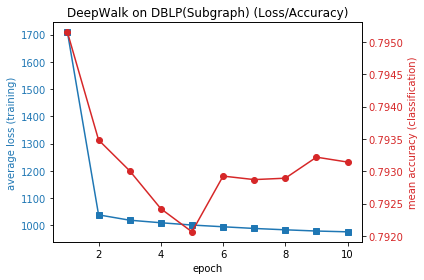

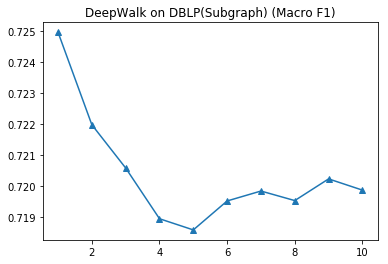

In [7]:
if run_dw:
    dwmodel = SGNS(dwpairs, cache=cache, **params_dw["model"])
    dwemb = dwmodel.embeddings[str(params_dw["model"]["iterations"])]

    print("Eval DW: ", eval_model(dwemb, dataset=dataset))
    # gensim_w2v = Word2Vec(dwpairs.sentences, negative=params_dw["pairs"]["neg_samples"], sample=params_dw["pairs"]["sample"], min_count=params_dw["pairs"]["min_count"], size=params_dw["model"]["dim"], iter=params_dw["model"]["iterations"], window=params_dw["pairs"]["window_size"], sg=1, alpha=params_dw["model"]["alpha"], hs=0, compute_loss=True)
    # print("Eval Gensim DW: ", eval_model(gensim_w2v.wv, dataset=dataset))
    
    plot_evals(dwmodel, title="DeepWalk on DBLP(Subgraph)", dataset=dataset)

## DW+D2V

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval D2VDW:  [(0.7773704824681624, 0.0030166976117977666), (0.8337705984388553, 0.00242517842314187)]


Evaluating model: 100%|██████████| 10/10 [11:29<00:00, 68.97s/it]


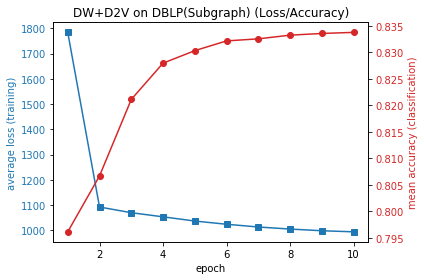

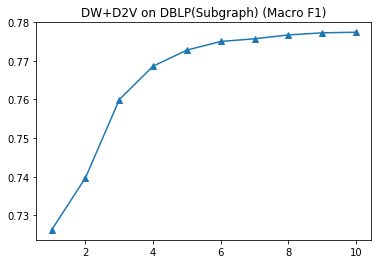

In [8]:
if run_d2v and run_dw:
    class D2VDWModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vdwmodel = D2VDWModel()
    
    for epoch in d2vmodel.embeddings.keys():
        d2v_emb_epoch = d2vmodel.embeddings[epoch]
        dw_emb_epoch = dwmodel.embeddings[epoch]
        d2v_loss_epoch = d2vmodel.losses[epoch]
        dw_loss_epoch = dwmodel.losses[epoch]
        
        d2vdwmodel.embeddings[epoch] = dict()
        for k in d2v_emb_epoch.keys():
            a = d2v_emb_epoch[k]
            b = dw_emb_epoch[k]
            d2vdwmodel.embeddings[epoch][k] = np.concatenate((a, b))
        d2vdwmodel.losses[epoch] = d2v_loss_epoch + dw_loss_epoch
    
    print("Eval D2VDW: ", eval_model(d2vdwmodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vdwmodel, title="DW+D2V on DBLP(Subgraph)", dataset=dataset)

## JCE-CNC

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Concat):  [(0.7690505316072408, 0.003553299995061916), (0.8285884648742412, 0.002593515120612155)]


Evaluating model: 100%|██████████| 10/10 [11:23<00:00, 68.36s/it]


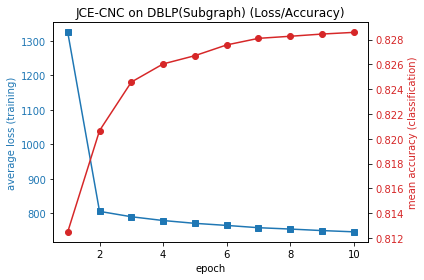

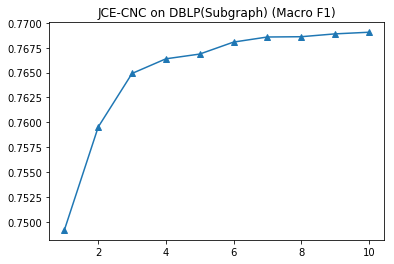

In [9]:
if run_jce:
    jceemb_concat = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_concat)

    print("Eval JCE (Concat): ", eval_model(jceemb_concat.embeddings[str(params_jce_concat["iterations"])], dataset=dataset))
    plot_evals(jceemb_concat, title="JCE-CNC on DBLP(Subgraph)", dataset=dataset)

## JCE-CMP

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (Compare):  [(0.7637026803985416, 0.0026830562308423306), (0.8224360364267129, 0.0015519610829971338)]


Evaluating model: 100%|██████████| 10/10 [07:34<00:00, 45.48s/it]


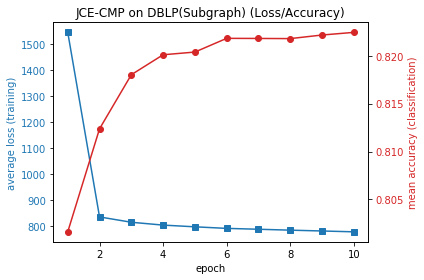

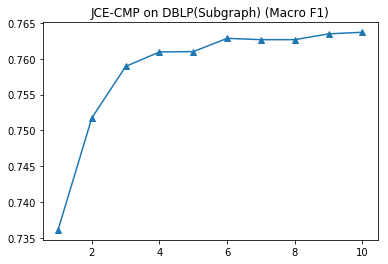

In [10]:
if run_jce:
    jceemb_compare = JCE(data=[d2vpairs, dwpairs], cache=cache, **params_jce_compare)

    print("Eval JCE (Compare): ", eval_model(jceemb_compare.embeddings[str(params_jce_compare["iterations"])], dataset=dataset))
    plot_evals(jceemb_compare, title="JCE-CMP on DBLP(Subgraph)", dataset=dataset)

## JCE-DW/JCE-D2V

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-D2V:  [(0.4933207082035193, 0.004502664298415121), (0.5990568083261059, 0.0032572780482759307)]


Evaluating model: 100%|██████████| 10/10 [04:52<00:00, 29.26s/it]


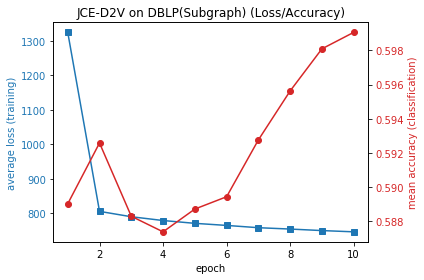

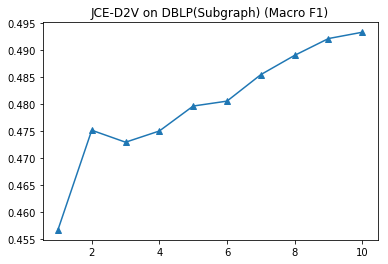

Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE-DW:  [(0.7138979703633488, 0.004678058466584452), (0.788605810928014, 0.0034562957511003116)]


Evaluating model: 100%|██████████| 10/10 [05:10<00:00, 31.07s/it]


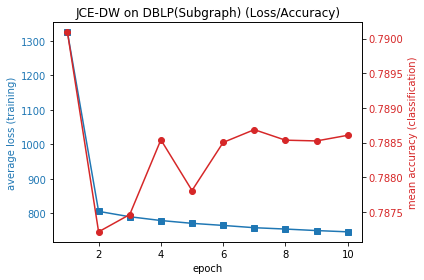

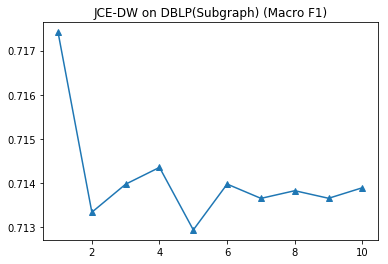

In [11]:
if run_jce:
    class JCESplitModel:
        def __init__(self):
            self.embeddings = dict()
            self.losses = dict()
    
    d2vjcemodel = JCESplitModel()
    dwjcemodel = JCESplitModel()
    
    for epoch in jceemb_concat.embeddings.keys():
        jceemb_epoch = jceemb_concat.embeddings[epoch]
        jceloss_epoch = jceemb_concat.losses[epoch]
                
        d2vjcemodel.embeddings[epoch] = dict()
        dwjcemodel.embeddings[epoch] = dict()
        for k in jceemb_epoch.keys():
            a = jceemb_epoch[k]
            half = len(a)//2
            d2vjcemodel.embeddings[epoch][k] = a[:half]
            dwjcemodel.embeddings[epoch][k] = a[half:]
        d2vjcemodel.losses[epoch] = jceloss_epoch
        dwjcemodel.losses[epoch] = jceloss_epoch
    
    print("Eval JCE-D2V: ", eval_model(d2vjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(d2vjcemodel, title="JCE-D2V on DBLP(Subgraph)", dataset=dataset)
    
    print("Eval JCE-DW: ", eval_model(dwjcemodel.embeddings['10'], dataset=dataset))
    plot_evals(dwjcemodel, title="JCE-DW on DBLP(Subgraph)", dataset=dataset)

## SINE(Reprod.)

Using GPU
Loading cached embeddings...


Evaluating model:   0%|          | 0/10 [00:00<?, ?it/s]

Eval JCE (SINE):  [(0.761836562156397, 0.003643114112333647), (0.8216012575888986, 0.003263654046423683)]


Evaluating model: 100%|██████████| 10/10 [05:13<00:00, 31.32s/it]


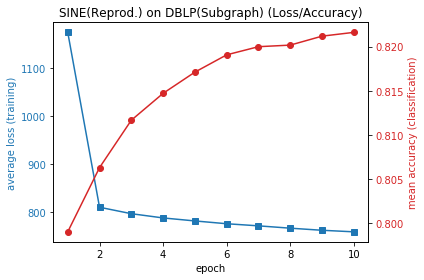

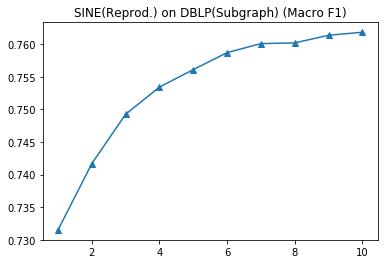

In [12]:
if run_jce:
    jceemb_sine = JCE(data=[d2vpairs, dwpairs], cache=cache, disable_grad=False, **params_jce_sine)

    print("Eval JCE (SINE): ", eval_model(jceemb_sine.embeddings[str(params_jce_sine["iterations"])], dataset=dataset))
    plot_evals(jceemb_sine, title="SINE(Reprod.) on DBLP(Subgraph)", dataset=dataset)